In [2]:
using CUDA, Colors, ColorMatrixConvention

In [3]:
function generate_kernel(f, img)
    r, c = Int32.(size(img))
    i = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    j = threadIdx().y + (blockIdx().y - 1) * blockDim().y
    
    @inbounds if i <= r && j <= c
        @inline img[i,j] = eltype(img)(f(i,j,r,c))
    end
    return
end

function generate(f, img::CuArray{C}, sync=true) where C<:Colorant
    threads = 16,16
    blocks = cld.(size(img), threads)
        @cuda threads=threads blocks=blocks generate_kernel(f, img)
        if sync
            CUDA.synchronize()
        end
    img
end

generate (generic function with 2 methods)

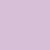

In [5]:
let 
    simple(i,j,r,c) = colorant"thistle"
    
    n = 50
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(simple, b)
    b
end

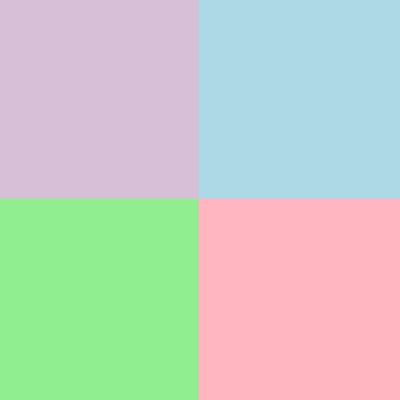

In [4]:
let 
    simple(i,j,r,c) = begin
        if i < r/2 && j < c/2
            colorant"thistle"
        elseif i < r/2 && j >= c/2
            colorant"lightblue"
        elseif i >= r/2 && j < c/2
            colorant"lightgreen"
        else
            colorant"lightpink"
        end
    end
    
    n = 400
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(simple, b)
    b
end

In [8]:
struct Literal{T} end
Base.:(*)(x, ::Type{Literal{T}}) where {T} = T(x)
const i32 = Literal{Int32}

i32 (alias for Literal{Int32})

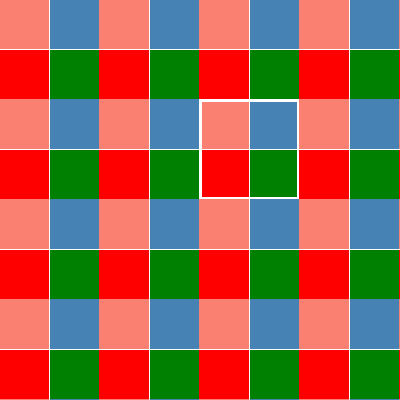

In [11]:
let 
    shader(i,j, r, c) = begin
        i, ii = divrem(i, 100i32)
        j, jj = divrem(j, 100i32)
        if i == 1 && j == 2 && (ii < 3 || jj < 3 || ii > 97 || jj > 97)
            return colorant"white" 
        end

        x  =  Float32(ii - 50i32) / 50.0f0
        y  =  Float32(jj - 50i32) / 50.0f0
        # if abs(x)  + abs(y) - 1.25f0 < 0.0f0
        # 	return colorant"salmon"
        # else 
        # 	return colorant"steelblue"
        # end
        if x < 0.0f0 && y < 0.0f0
            return colorant"salmon"
        elseif x < 0.0f0 && y > 0.0f0
            return colorant"steelblue"
        elseif x > 0.0f0 && y < 0.0f0
            return colorant"red"
        elseif x > 0.0f0 && y > 0.0f0
            return colorant"green"
        else
            return colorant"white"
        end
    end
    n = 400
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(shader, b)
    b
end

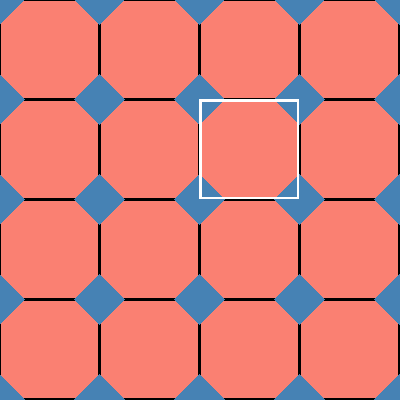

In [18]:
let 
    shader(i,j, r, c) = begin
        i, ii = divrem(i, 100i32)
        j, jj = divrem(j, 100i32)
        if i == 1 && j == 2 && (ii < 3 || jj < 3 || ii > 97 || jj > 97)
            return colorant"white" 
        end

        x  =  Float32(ii - 50i32) / 50.0f0
        y  =  Float32(jj - 50i32) / 50.0f0
        x = abs(x)
        y = abs(y)
        if x  + y - 1.5f0 < 0.0f0
        	if max(x,y) > 0.98
                return colorant"black"
            else
                return colorant"salmon"
            end
        else 
        	return colorant"steelblue"
        end
    end
    n = 400
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(shader, b)
    b
end